In [1]:

#Imports
import argparse
import numpy as np
import networkx as nx
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn import metrics, model_selection
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.extmath import softmax

In [97]:
args = {}
args.update({"weighted" : False})
args.update({"directed" : False})
args.update({"emb_dim" : 20})
args.update({"output" : "test_DeepWalk.txt"})
args.update({"walk_length" : 10})
args.update({"num_walks" : 2})
args.update({"window_size" : 10})
args.update({"SGD_iter" : 50})
args.update({"workers" : 8})

# Load CORA dataset for node classification

The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.

In [5]:
# Initialize graph 
G = nx.Graph()

path = "../Data/cora/cora_edges.txt"
edgelist = list(np.genfromtxt(path, delimiter=",", dtype=str)) 

# Add in all edges in the edgelist to G
for e in edgelist:
    G.add_edge(e[0], e[1]) 
    
path_classes = "../Data/cora/cora_node_labels.txt"
node_labels = list(np.genfromtxt(path_classes, delimiter=",", dtype=int))

node_labels_dict = {}
for i in np.arange(len(node_labels)):
    node_labels_dict.update({str(node_labels[i][0]): node_labels[i][1]-1})

In [6]:
y = []
for v in G.nodes():
    y.append(node_labels_dict.get(v))

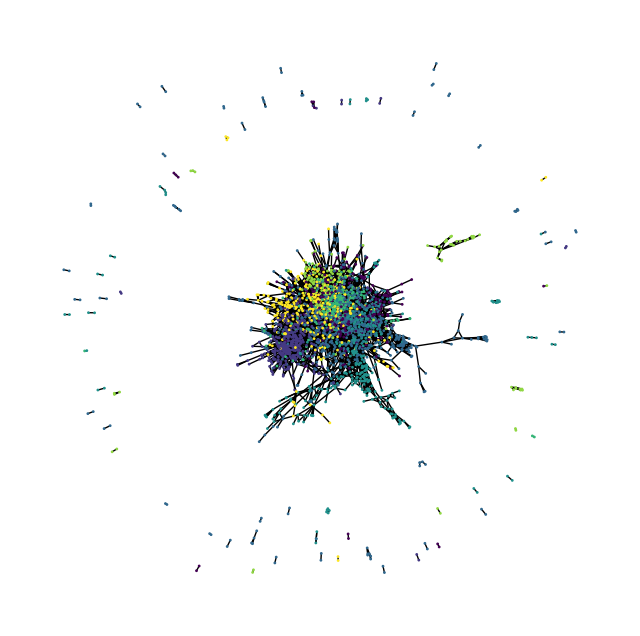

In [7]:
y = []
for v in G.nodes():
    y.append(node_labels_dict.get(v))


# plot the graph 
fig = plt.figure(figsize=[8,8], constrained_layout=False)
ax = fig.add_subplot()
nx.draw_networkx(G, ax=ax, pos=nx.spring_layout(G), labels={},
                 node_size=1, node_color=y, font_size=14, font_color="white")
plt.axis('off');
plt.savefig("cora_graph", bbox_inches="tight")

In [8]:
node_labels_dict

{'1': 2,
 '2': 5,
 '3': 4,
 '4': 4,
 '5': 3,
 '6': 3,
 '7': 6,
 '8': 2,
 '9': 2,
 '10': 6,
 '11': 2,
 '12': 1,
 '13': 3,
 '14': 0,
 '15': 2,
 '16': 2,
 '17': 4,
 '18': 2,
 '19': 2,
 '20': 2,
 '21': 6,
 '22': 4,
 '23': 1,
 '24': 3,
 '25': 4,
 '26': 6,
 '27': 2,
 '28': 3,
 '29': 2,
 '30': 5,
 '31': 0,
 '32': 2,
 '33': 0,
 '34': 2,
 '35': 4,
 '36': 4,
 '37': 2,
 '38': 4,
 '39': 1,
 '40': 4,
 '41': 6,
 '42': 3,
 '43': 1,
 '44': 2,
 '45': 0,
 '46': 4,
 '47': 2,
 '48': 0,
 '49': 3,
 '50': 0,
 '51': 0,
 '52': 3,
 '53': 6,
 '54': 1,
 '55': 6,
 '56': 1,
 '57': 6,
 '58': 4,
 '59': 2,
 '60': 2,
 '61': 4,
 '62': 0,
 '63': 3,
 '64': 4,
 '65': 0,
 '66': 1,
 '67': 0,
 '68': 3,
 '69': 2,
 '70': 0,
 '71': 6,
 '72': 3,
 '73': 2,
 '74': 4,
 '75': 3,
 '76': 0,
 '77': 3,
 '78': 2,
 '79': 6,
 '80': 6,
 '81': 2,
 '82': 3,
 '83': 4,
 '84': 2,
 '85': 3,
 '86': 4,
 '87': 5,
 '88': 5,
 '89': 6,
 '90': 6,
 '91': 2,
 '92': 2,
 '93': 4,
 '94': 3,
 '95': 3,
 '96': 3,
 '97': 0,
 '98': 2,
 '99': 6,
 '100': 3,
 '101': 

In [9]:
# Split the nodes into 80% training and 20% testing set

nodes_train = []
nodes_test = []
for v in list(G.nodes()):
    U = np.random.rand()
    if U<0.8:
        nodes_train.append(v)
    else:
        nodes_test.append(v)

# DeepWalk node embedding

In [13]:
def RW(G, x0=None, steps=1, return_history=False):
    # simple symmetric random walk on graph G 
    # initialization at x0
    if x0 is None:
        x = np.random.choice(G.nodes())
    else:
        x = x0
    
    history = []
    for i in np.arange(steps):
        if len(list(G.neighbors(x))) == 0:
            print("RW is stuck at isolated node")
            x = np.random.choice(G.nodes()) # re-initialize uniformly at random
        else: 
            x = np.random.choice(list(G.neighbors(x)))

        if return_history:
            history.append(x)
        
    if not return_history: 
        return x 
    else: 
        return history

In [89]:
# Generate RW trajectories of given length at every node -- corpus of RWs 
n_RWs = args.get("num_walks")
length_RWs = args.get("walk_length")
nodes = list(G.nodes())
RW_corpus = []
for v in nodes:
    for k in np.arange(n_RWs):
        RW_trajectory = RW(G, x0=v, steps=length_RWs, return_history=True)
        RW_corpus.append(RW_trajectory)

In [90]:
RW_corpus

[['9', '752', '436', '259', '1032', '1329', '1569', '431', '1570', '1610'],
 ['545', '1', '436', '15', '737', '1117', '709', '1117', '737', '15'],
 ['1', '15', '9', '15', '545', '1', '436', '9', '259', '8'],
 ['15', '269', '15', '444', '15', '747', '15', '614', '2108', '1954'],
 ['9', '436', '15', '269', '259', '752', '259', '1112', '1340', '1571'],
 ['752', '259', '752', '545', '752', '9', '259', '545', '1', '545'],
 ['15', '394', '15', '385', '15', '614', '269', '233', '614', '617'],
 ['259', '752', '259', '752', '15', '709', '15', '747', '300', '2084'],
 ['198', '750', '2486', '750', '2486', '2481', '566', '2443', '930', '72'],
 ['602', '1742', '602', '612', '720', '88', '2246', '88', '720', '612'],
 ['4', '602', '566', '119', '637', '2175', '1574', '1433', '965', '966'],
 ['634', '612', '717', '612', '2677', '612', '2506', '612', '2386', '2677'],
 ['4', '602', '4', '602', '4', '464', '478', '746', '1886', '746'],
 ['484', '553', '58', '566', '1791', '524', '1791', '566', '1728', '5

In [91]:
def learn_embeddings(walks, args, verbose=False):
    '''
    Learn embeddings by optimizing the Skipgram objective using SGD.
    '''
    walks_str = []
    for walk in walks:
        walks_str.append([str(x) for x in walk])
    
    model = Word2Vec(walks_str,
                     vector_size=args.get("emb_dim"),
                     window=args.get("window_size"),
                     min_count=0, sg=1,
                     workers=args.get("workers"),
                     epochs=200)
    model.wv.save_word2vec_format(args.get("output"))

    # Store just the words + their trained embeddings as a numpy dictionary
    word_vectors = model.wv
    my_dict = dict({})
    keys = []
    for idx, key in enumerate(model.wv.key_to_index):
        my_dict[key] = model.wv[key]

    if verbose:
        # print("motifs embedded : {}".format(my_dict.keys()))
        for word in my_dict.keys():
            print("node \n {} ===> emb {}".format(word, my_dict.get(word)))
    # self.sort_dict(my_dict)
    return my_dict

In [92]:
my_dict = learn_embeddings(RW_corpus, args, verbose=True)
print('number of nodes embedded', len(my_dict.keys()))

node 
 164 ===> emb [ 0.47022936  0.1952346   0.04058505  0.39781642 -0.8725767  -0.31828
 -0.01234735  1.328128   -0.63402426  0.27359518  0.3591206  -0.15210076
 -0.09427285 -0.09197122  0.4260379   0.24610047  0.92664415 -0.28231856
 -0.11951188  0.01712944]
node 
 428 ===> emb [-0.0567732  -0.24398828  0.14221987 -0.18485956  0.1925147  -0.04625418
 -0.7418837   1.1591623  -0.4052051   0.43314472 -1.3150418   0.19278106
  0.40418246 -0.16128066  0.4579476   0.30205485  0.99554384  0.1508925
  0.5138662  -0.7312572 ]
node 
 748 ===> emb [-0.55308735 -0.84967434 -0.2990822   0.03917956  0.34828317  0.11533335
 -1.5991646   0.7180755  -0.91753596  0.68117344  0.06900111 -0.25884104
  0.60614944  0.20179953  0.12777188  0.23579592  0.57261837  0.1724053
 -0.12640247 -0.74603844]
node 
 566 ===> emb [ 0.23834506  0.04771394 -0.5142837  -0.62025803  0.4753586   0.4196061
  0.12950876  0.7505311  -0.6655538   1.4767535   0.5283936  -0.5018623
  0.31674212 -0.39193666  0.02362948  0.241370

In [93]:
# make matrix of node embeddings
X = []
for v in list(G.nodes()):
    emb = my_dict.get(v)
    if emb is None: # embedding for this node has not been learned 
        emb = np.random.rand(args.get("emb_dim"))
    X.append(emb)
X = np.asarray(X)
print("X.shape=", X.shape)

# make array of node lables 
y = []
for v in list(G.nodes()):
    label = node_labels_dict.get(v)
    if label is None: # embedding for this node has not been learned 
        label = np.random.choice(np.arange(7))
    y.append(label)
y = np.asarray(y)
print("y.shape=", y.shape)


X.shape= (2708, 20)
y.shape= (2708,)


In [94]:
X

array([[ 0.16395235, -2.24946046,  0.25346914, ...,  1.32569611,
         1.7645247 , -2.04955649],
       [ 0.04470623, -1.64145052, -0.25908643, ...,  1.66995156,
         1.57704461, -1.71477973],
       [ 0.31796953, -1.31410062, -0.23188181, ...,  1.40912461,
         2.64486098, -1.40609896],
       ...,
       [-0.73962265,  0.27464491,  1.51978874, ..., -0.33927873,
        -1.33355868, -1.78469706],
       [ 2.86163163, -1.93418133,  0.40292665, ...,  0.41210702,
        -0.25292501, -2.7969327 ],
       [ 1.94746149, -0.97913951,  0.17461441, ..., -0.65483123,
         0.13256299, -2.37167835]])

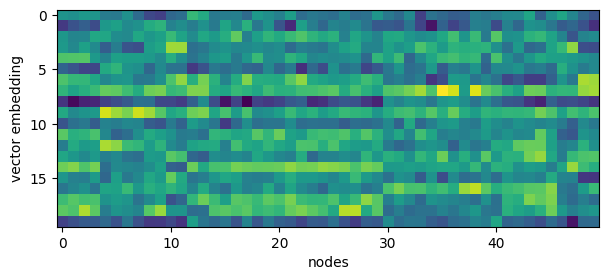

In [98]:
# plot the learned vector embedding
fig = plt.figure(figsize=[7,5], constrained_layout=False)
ax = fig.add_subplot()
ax.set_xlabel("nodes")
ax.set_ylabel("vector embedding")
plt.imshow(X[:50,:].T)
#plt.imshow(X.T)


## Multiclass node classification using Multinomial Logistic Regression

In [99]:
def list2onehot(y, list_classes=None):
    """
    y = list of class lables of length n
    output = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    """
    if list_classes is None:
        list_classes = list(np.sort(c))
    Y = np.zeros(shape = [len(y), len(list_classes)], dtype=int)
    for i in np.arange(Y.shape[0]):
        for j in np.arange(len(list_classes)):
            if y[i] == list_classes[j]:
                Y[i,j] = 1
    return Y

In [100]:
def multiclass_accuracy_metrics(Y_test, P_pred, class_labels=None, use_opt_threshold=False):
    # y_test = multiclass one-hot encoding  labels 
    # Q = predicted probability for y_test
    # compuate various classification accuracy metrics
    results_dict = {}
    y_test = []
    y_pred = []
    for i in np.arange(Y_test.shape[0]):
        for j in np.arange(Y_test.shape[1]):
            if Y_test[i,j] == 1:
                y_test.append(j)
            if P_pred[i,j] == np.max(P_pred[i,:]):
                # print('!!!', np.where(P_pred[i,:]==np.max(P_pred[i,:])))
                y_pred.append(j)
            
    confusion_mx = metrics.confusion_matrix(y_test, y_pred)
    results_dict.update({'confusion_mx':confusion_mx})
    results_dict.update({'Accuracy':np.trace(confusion_mx)/np.sum(np.sum(confusion_mx))})
    print('!!! confusion_mx', confusion_mx)
    print('!!! Accuracy', results_dict.get('Accuracy'))
    
    
    return results_dict

In [101]:
Y = list2onehot(y, list_classes=[0, 1, 2, 3, 4, 5, 6])

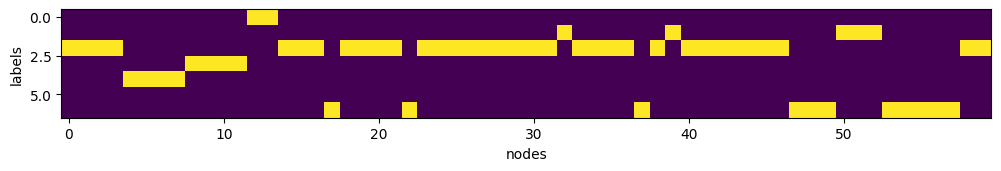

In [102]:
# plot the learned vector embedding
fig = plt.figure(figsize=[12,5], constrained_layout=False)
ax = fig.add_subplot()
ax.set_xlabel("nodes")
ax.set_ylabel("labels")
plt.imshow(Y[:60,:].T)


In [103]:
## split into train and test set 
X_train = []
X_test = []
Y_test = []
Y_train = []

nodes = list(G.nodes())
for i in np.arange(len(nodes)):
    v = nodes[i]
    if v in nodes_train: 
        X_train.append(X[i,:])
        Y_train.append(Y[i,:])
    else:
        X_test.append(X[i,:])
        Y_test.append(Y[i,:])

X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
Y_train = np.asarray(Y_train)
Y_test = np.asarray(Y_test)

y_test = []
for i in np.arange(Y_test.shape[0]):
    for j in np.arange(Y_test.shape[1]):
        if Y_test[i,j] == 1:
            y_test.append(j)

y_train = []
for i in np.arange(Y_train.shape[0]):
    for j in np.arange(Y_train.shape[1]):
        if Y_train[i,j] == 1:
            y_train.append(j)

print('y_train.shape', Y_train.shape)
print('y_test.shape', Y_test.shape)

y_train.shape (2179, 7)
y_test.shape (529, 7)


In [104]:
def fit_MLR_GD(Y, H, W0=None, sub_iter=100, stopping_diff=0.01):
    '''
    Convex optimization algorithm for Multiclass Logistic Regression using Gradient Descent 
    Y = (n x k), H = (p x n) (\Phi in lecture note), W = (p x k)
    Multiclass Logistic Regression: Y ~ vector of discrete RVs with PMF = sigmoid(H.T @ W)
    MLE -->
    Find \hat{W} = argmin_W ( sum_j ( log(1+exp(H_j.T @ W) ) - Y.T @ H.T @ W ) )
    '''
    k = Y.shape[1] # number of classes 
    if W0 is None:
        W0 = np.random.rand(H.shape[0],k) #If initial coefficients W0 is None, randomly initialize  

    W1 = W0.copy()
    i = 0
    grad = np.ones(W0.shape)
    while (i < sub_iter) and (np.linalg.norm(grad) > stopping_diff):
        Q = 1/(1+np.exp(-H.T @ W1))  # probability matrix, same shape as Y
        # grad = H @ (Q - Y).T + alpha * np.ones(W0.shape[1])
        grad = H @ (Q - Y)
        W1 = W1 - (np.log(i+1) / (((i + 10) ** (0.5)))) * grad
        i = i + 1
        if i % 1 == 0:
            print('iter %i, grad_norm %f' %(i, np.linalg.norm(grad)))
    return W1

In [105]:
X_train.shape

(2179, 20)

In [106]:
Y_train.shape

(2179, 7)

In [107]:
### Fit Multinomial Logistic Regression model



H_train = np.vstack((np.ones(X_train.shape[0]), X_train.T))  # add first row of 1's for bias features 

W = fit_MLR_GD(Y=Y_train, H=H_train) 
print('!! W.shape', W.shape)

# Get predicted probabilities 
H_test = np.vstack((np.ones(X_test.shape[0]), X_test.T))
Q = softmax(H_test.T @ W.copy()) # predicted probabilities for y_test # Uses sklearn's softmax for numerical stability

print('!!! Y_test.shape', Y_test.shape)

print('!!! Q.shape', Q.shape)

iter 1, grad_norm 9615.106512
iter 2, grad_norm 9615.106512
iter 3, grad_norm 3569.456862
iter 4, grad_norm 5805.489039
iter 5, grad_norm 6835.914625
iter 6, grad_norm 2950.636385
iter 7, grad_norm 3904.522622
iter 8, grad_norm 2865.248789
iter 9, grad_norm 6037.601566
iter 10, grad_norm 1906.801816
iter 11, grad_norm 2614.637063
iter 12, grad_norm 2998.368830
iter 13, grad_norm 3403.751579
iter 14, grad_norm 2770.331310
iter 15, grad_norm 1218.331943
iter 16, grad_norm 1534.935983
iter 17, grad_norm 2247.535719
iter 18, grad_norm 2293.393672
iter 19, grad_norm 3232.994907
iter 20, grad_norm 2594.129734
iter 21, grad_norm 1321.319097
iter 22, grad_norm 2454.208681
iter 23, grad_norm 2235.468636
iter 24, grad_norm 2353.360303
iter 25, grad_norm 2947.668394
iter 26, grad_norm 3567.506904
iter 27, grad_norm 3060.787697
iter 28, grad_norm 2952.028918
iter 29, grad_norm 2180.155184
iter 30, grad_norm 5108.396592
iter 31, grad_norm 2197.659635
iter 32, grad_norm 2291.587853
iter 33, grad_nor

/var/folders/0c/0z7vdgm924n7cfct5sbdp4nc0000gr/T/ipykernel_40504/1021612928.py:17: RuntimeWarning: overflow encountered in exp
  Q = 1/(1+np.exp(-H.T @ W1))  # probability matrix, same shape as Y


In [108]:
results_dict = multiclass_accuracy_metrics(Y_test=Y_test, P_pred=Q)
confusion_mx = results_dict.get('confusion_mx')

!!! confusion_mx [[ 40   4  20   4   0   5   1]
 [  0  59   7   2   0   1   0]
 [  1   6 125   9   0   3   4]
 [  0   0  25  54   0   1   0]
 [  2  14  21   9   0   2   3]
 [  2   0  12   3   0  21   0]
 [  1   0  16  12   0   8  32]]
!!! Accuracy 0.6257088846880907


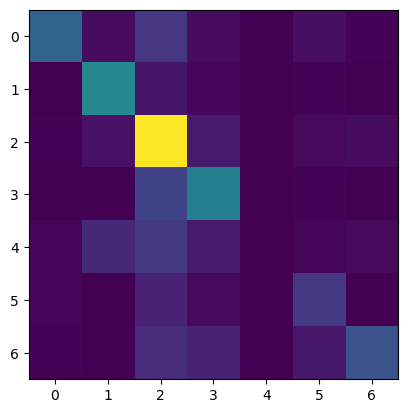

In [109]:
plt.imshow(confusion_mx)

# Wrap the entire pipeline

In [51]:
args = {}
args.update({"weighted" : False})
args.update({"directed" : False})
args.update({"emb_dim" : 20})
args.update({"output" : "test_DeepWalk.txt"})
args.update({"walk_length" : 10})
args.update({"num_walks" : 2})
args.update({"window_size" : 10})
args.update({"SGD_iter" : 50})
args.update({"workers" : 8})

In [52]:
def node_classicifation(G, node_labels, args, nodes_train, 
                        classes=[0,1,2,3,4,5,6]):
    ### node classification using DeepWalk node embedding 
    ### and multinomial logistic regression
    
    print("Generating RW corpus...")
    ## Generate RW trajectories of given length at every node -- corpus of RWs 
    n_RWs = args.get("num_walks")
    length_RWs = args.get("walk_length")
    nodes = list(G.nodes())
    RW_corpus = []
    for v in nodes:
        for k in np.arange(n_RWs):
            RW_trajectory = RW(G, x0=v, steps=length_RWs, return_history=True)
            RW_corpus.append(RW_trajectory)
            
    print("Learning DeepWalk embedding...")
    ## Learn DeepWalk embedding 
    my_dict = learn_embeddings(RW_corpus, args, verbose=False)

    ## make matrix of node embeddings
    X = []
    for v in list(G.nodes()):
        emb = my_dict.get(v)
        if emb is None: # embedding for this node has not been learned 
            emb = np.random.rand(args.get("emb_dim"))
        X.append(emb)
    X = np.asarray(X)

    ## make array of node lables 
    y = []
    for v in list(G.nodes()):
        label = node_labels_dict.get(v)
        if label is None: # embedding for this node has not been learned 
            label = np.random.choice(np.arange(7))
        y.append(label)
    y = np.asarray(y)
    
    ## split into train and test set 
    X_train = []
    X_test = []
    Y_test = []
    Y_train = []

    nodes = list(G.nodes())
    for i in np.arange(len(nodes)):
        v = nodes[i]
        if v in nodes_train: 
            X_train.append(X[i,:])
            Y_train.append(Y[i,:])
        else:
            X_test.append(X[i,:])
            Y_test.append(Y[i,:])

    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    Y_train = np.asarray(Y_train)
    Y_test = np.asarray(Y_test)

    y_test = []
    for i in np.arange(Y_test.shape[0]):
        for j in np.arange(Y_test.shape[1]):
            if Y_test[i,j] == 1:
                y_test.append(j)

    y_train = []
    for i in np.arange(Y_train.shape[0]):
        for j in np.arange(Y_train.shape[1]):
            if Y_train[i,j] == 1:
                y_train.append(j)

    print("Fitting Multinomial Logistic Regression model...")
    ## Fit Multinomial Logistic Regression model
    H_train = np.vstack((np.ones(X_train.shape[0]), X_train.T))  # add first row of 1's for bias features 
    W = fit_MLR_GD(Y=Y_train, H=H_train) 
    H_test = np.vstack((np.ones(X_test.shape[0]), X_test.T))
    Q = softmax(H_test.T @ W.copy()) # predicted probabilities for y_test # Uses sklearn's softmax for numerical stability

    results_dict = multiclass_accuracy_metrics(Y_test=Y_test, P_pred=Q)
    confusion_mx = results_dict.get('confusion_mx')
    acc = results_dict.get('Accuracy')

    return confusion_mx, acc

In [53]:
confusion_mx, acc = node_classicifation(G, node_labels, args, nodes_train, 
                                        classes=[0,1,2,3,4,5,6])

Generating RW corpus...
Learning DeepWalk embedding...
Fitting Multinomial Logistic Regression model...
iter 1, grad_norm 7852.630737
iter 2, grad_norm 7852.630737
iter 3, grad_norm 4269.998291
iter 4, grad_norm 6565.338670
iter 5, grad_norm 2473.813529
iter 6, grad_norm 8217.027676
iter 7, grad_norm 3928.923328
iter 8, grad_norm 2340.678869
iter 9, grad_norm 4928.052673
iter 10, grad_norm 3237.505661
iter 11, grad_norm 2218.613573
iter 12, grad_norm 2579.714963
iter 13, grad_norm 2899.464487
iter 14, grad_norm 3013.276414
iter 15, grad_norm 2511.023893
iter 16, grad_norm 1888.136292
iter 17, grad_norm 2005.440350
iter 18, grad_norm 2089.770305
iter 19, grad_norm 3146.672731
iter 20, grad_norm 2462.753691
iter 21, grad_norm 2585.095314
iter 22, grad_norm 2494.007106
iter 23, grad_norm 2306.593901
iter 24, grad_norm 2230.479654
iter 25, grad_norm 2426.959146
iter 26, grad_norm 2097.868548
iter 27, grad_norm 2092.063254
iter 28, grad_norm 2779.221811
iter 29, grad_norm 2262.792093
iter 3

/var/folders/0c/0z7vdgm924n7cfct5sbdp4nc0000gr/T/ipykernel_40504/1021612928.py:17: RuntimeWarning: overflow encountered in exp
  Q = 1/(1+np.exp(-H.T @ W1))  # probability matrix, same shape as Y


Generating RW corpus...
Learning DeepWalk embedding...
Fitting Multinomial Logistic Regression model...
iter 1, grad_norm 8848.740745
iter 2, grad_norm 8848.740745
iter 3, grad_norm 3324.174726
iter 4, grad_norm 5599.544516
iter 5, grad_norm 6712.743337
iter 6, grad_norm 4197.331846
iter 7, grad_norm 7399.359050
iter 8, grad_norm 3072.165314
iter 9, grad_norm 2787.212354
iter 10, grad_norm 2916.318691
iter 11, grad_norm 2781.317736
iter 12, grad_norm 2845.549909
iter 13, grad_norm 3912.971199
iter 14, grad_norm 4876.659322
iter 15, grad_norm 2426.465309
iter 16, grad_norm 3072.436368
iter 17, grad_norm 2222.996482
iter 18, grad_norm 2274.036119
iter 19, grad_norm 2367.806114
iter 20, grad_norm 2800.334987
iter 21, grad_norm 3742.305552
iter 22, grad_norm 2315.355019
iter 23, grad_norm 2558.896308
iter 24, grad_norm 2678.397872
iter 25, grad_norm 4425.814628
iter 26, grad_norm 2773.113313
iter 27, grad_norm 2182.820780
iter 28, grad_norm 2186.162579
iter 29, grad_norm 2174.513942
iter 3

/var/folders/0c/0z7vdgm924n7cfct5sbdp4nc0000gr/T/ipykernel_40504/1021612928.py:17: RuntimeWarning: overflow encountered in exp
  Q = 1/(1+np.exp(-H.T @ W1))  # probability matrix, same shape as Y


Learning DeepWalk embedding...
Fitting Multinomial Logistic Regression model...
iter 1, grad_norm 11632.399068
iter 2, grad_norm 11632.399068
iter 3, grad_norm 3571.770247
iter 4, grad_norm 5464.328404
iter 5, grad_norm 5837.403254
iter 6, grad_norm 3355.251761
iter 7, grad_norm 4390.634862
iter 8, grad_norm 3017.069190
iter 9, grad_norm 1994.507551
iter 10, grad_norm 2201.336957
iter 11, grad_norm 3795.051313
iter 12, grad_norm 2902.454096
iter 13, grad_norm 3175.963995
iter 14, grad_norm 3922.850427
iter 15, grad_norm 2887.062985
iter 16, grad_norm 1263.661498
iter 17, grad_norm 2108.788484
iter 18, grad_norm 5288.205377
iter 19, grad_norm 2204.018474
iter 20, grad_norm 2670.553603
iter 21, grad_norm 2742.475202
iter 22, grad_norm 4056.978192
iter 23, grad_norm 2917.146878
iter 24, grad_norm 922.887224
iter 25, grad_norm 1119.171552
iter 26, grad_norm 1924.282542
iter 27, grad_norm 3092.361213
iter 28, grad_norm 3586.747919
iter 29, grad_norm 4207.137585
iter 30, grad_norm 2929.22239

/var/folders/0c/0z7vdgm924n7cfct5sbdp4nc0000gr/T/ipykernel_40504/1021612928.py:17: RuntimeWarning: overflow encountered in exp
  Q = 1/(1+np.exp(-H.T @ W1))  # probability matrix, same shape as Y


Learning DeepWalk embedding...
Fitting Multinomial Logistic Regression model...
iter 1, grad_norm 5283.008532
iter 2, grad_norm 5283.008532
iter 3, grad_norm 4542.486544
iter 4, grad_norm 3998.597969
iter 5, grad_norm 6354.210342
iter 6, grad_norm 4809.489825
iter 7, grad_norm 5853.333777
iter 8, grad_norm 2315.128960
iter 9, grad_norm 2179.610104
iter 10, grad_norm 5136.865072
iter 11, grad_norm 3568.273913
iter 12, grad_norm 2986.099650
iter 13, grad_norm 1529.322053
iter 14, grad_norm 1292.329169
iter 15, grad_norm 4074.768707
iter 16, grad_norm 1981.093864
iter 17, grad_norm 2997.934252
iter 18, grad_norm 2445.103822
iter 19, grad_norm 1855.496995
iter 20, grad_norm 1817.991521
iter 21, grad_norm 1667.039769
iter 22, grad_norm 1766.308881
iter 23, grad_norm 1782.730395
iter 24, grad_norm 2332.339989
iter 25, grad_norm 1961.988875
iter 26, grad_norm 2052.172145
iter 27, grad_norm 2288.977587
iter 28, grad_norm 2459.988297
iter 29, grad_norm 2128.543273
iter 30, grad_norm 1836.085137

/var/folders/0c/0z7vdgm924n7cfct5sbdp4nc0000gr/T/ipykernel_40504/1021612928.py:17: RuntimeWarning: overflow encountered in exp
  Q = 1/(1+np.exp(-H.T @ W1))  # probability matrix, same shape as Y


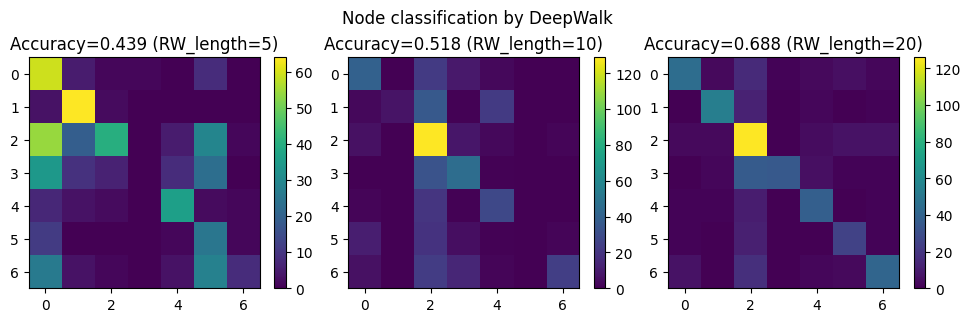

In [54]:
fig = plt.figure(figsize=[12,3], constrained_layout=False)
network_list = [""]
k_list = [5, 10, 20]
outer_grid = gridspec.GridSpec(nrows=1, ncols=len(k_list), wspace=0.1, hspace=0.1)

for i in range(len(k_list)): 
    inner_grid = outer_grid[0,i].subgridspec(1, 1, wspace=0, hspace=0)
    ax = fig.add_subplot(inner_grid[0, 0])
    k = k_list[i]
    args.update({"walk_length" : k})
    confusion_mx, acc = node_classicifation(G, node_labels, args, nodes_train, 
                                        classes=[0,1,2,3,4,5,6])

    im = ax.imshow(confusion_mx)
    ax.set_title("Accuracy={} (RW_length={})".format(np.round(acc,3), k))
    #cbar_ax = ax.inset_axes([0.92, 0.15, 0.01, 0.7])
    fig.colorbar(im, ax=ax)
    
plt.suptitle("Node classification by DeepWalk", y=1.04)
plt.savefig("cora_node_classification1", bbox_inches="tight")

## Use spectral embedding

In [31]:
# Spectral Embedding
L = nx.normalized_laplacian_matrix(G).todense()
#A = nx.adjacency_matrix(G).todense()
w, v = np.linalg.eigh(-L)
#d = 2
#U = np.array(eigenvectors[:, :d])

<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


In [32]:
def node_classicifation_spectral(G, node_labels, args, nodes_train, top_evecs,
                        classes=[0,1,2,3,4,5,6]):
    ### node classification using DeepWalk node embedding 
    ### and multinomial logistic regression

    ## make matrix of node embeddings
    X = np.array(top_evecs[:, :args.get("emb_dim")])

    ## make array of node lables 
    y = []
    for v in list(G.nodes()):
        label = node_labels_dict.get(v)
        if label is None: # embedding for this node has not been learned 
            label = np.random.choice(np.arange(7))
        y.append(label)
    y = np.asarray(y)
    
    ## split into train and test set 
    X_train = []
    X_test = []
    Y_test = []
    Y_train = []

    nodes = list(G.nodes())
    for i in np.arange(len(nodes)):
        v = nodes[i]
        if v in nodes_train: 
            X_train.append(X[i,:])
            Y_train.append(Y[i,:])
        else:
            X_test.append(X[i,:])
            Y_test.append(Y[i,:])

    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    Y_train = np.asarray(Y_train)
    Y_test = np.asarray(Y_test)

    y_test = []
    for i in np.arange(Y_test.shape[0]):
        for j in np.arange(Y_test.shape[1]):
            if Y_test[i,j] == 1:
                y_test.append(j)

    y_train = []
    for i in np.arange(Y_train.shape[0]):
        for j in np.arange(Y_train.shape[1]):
            if Y_train[i,j] == 1:
                y_train.append(j)

    print("Fitting Multinomial Logistic Regression model...")
    ## Fit Multinomial Logistic Regression model
    H_train = np.vstack((np.ones(X_train.shape[0]), X_train.T))  # add first row of 1's for bias features 
    W = fit_MLR_GD(Y=Y_train, H=H_train) 
    H_test = np.vstack((np.ones(X_test.shape[0]), X_test.T))
    Q = softmax(H_test.T @ W.copy()) # predicted probabilities for y_test # Uses sklearn's softmax for numerical stability

    results_dict = multiclass_accuracy_metrics(Y_test=Y_test, P_pred=Q)
    confusion_mx = results_dict.get('confusion_mx')
    acc = results_dict.get('Accuracy')

    return confusion_mx, acc

Fitting Multinomial Logistic Regression model...
iter 1, grad_norm 3019.485990
iter 2, grad_norm 3019.485990
iter 3, grad_norm 931.578292
iter 4, grad_norm 1641.955744
iter 5, grad_norm 2026.822017
iter 6, grad_norm 2759.352160
iter 7, grad_norm 3239.003089
iter 8, grad_norm 2235.406784
iter 9, grad_norm 931.578292
iter 10, grad_norm 1641.955723
iter 11, grad_norm 2470.268081
iter 12, grad_norm 931.578292
iter 13, grad_norm 2094.498563
iter 14, grad_norm 1641.955744
iter 15, grad_norm 931.578292
iter 16, grad_norm 2153.992980
iter 17, grad_norm 3027.093033
iter 18, grad_norm 931.578292
iter 19, grad_norm 2211.888712
iter 20, grad_norm 1641.955420
iter 21, grad_norm 2094.498563
iter 22, grad_norm 956.645423
iter 23, grad_norm 3027.093033
iter 24, grad_norm 931.578292
iter 25, grad_norm 2235.047241
iter 26, grad_norm 2153.993554
iter 27, grad_norm 1641.955744
iter 28, grad_norm 2094.498562
iter 29, grad_norm 2708.120806
iter 30, grad_norm 1641.955744
iter 31, grad_norm 931.578292
iter 32

/var/folders/0c/0z7vdgm924n7cfct5sbdp4nc0000gr/T/ipykernel_40504/1021612928.py:17: RuntimeWarning: overflow encountered in exp
  Q = 1/(1+np.exp(-H.T @ W1))  # probability matrix, same shape as Y
/var/folders/0c/0z7vdgm924n7cfct5sbdp4nc0000gr/T/ipykernel_40504/1021612928.py:17: RuntimeWarning: overflow encountered in exp
  Q = 1/(1+np.exp(-H.T @ W1))  # probability matrix, same shape as Y
/var/folders/0c/0z7vdgm924n7cfct5sbdp4nc0000gr/T/ipykernel_40504/1021612928.py:17: RuntimeWarning: overflow encountered in exp
  Q = 1/(1+np.exp(-H.T @ W1))  # probability matrix, same shape as Y


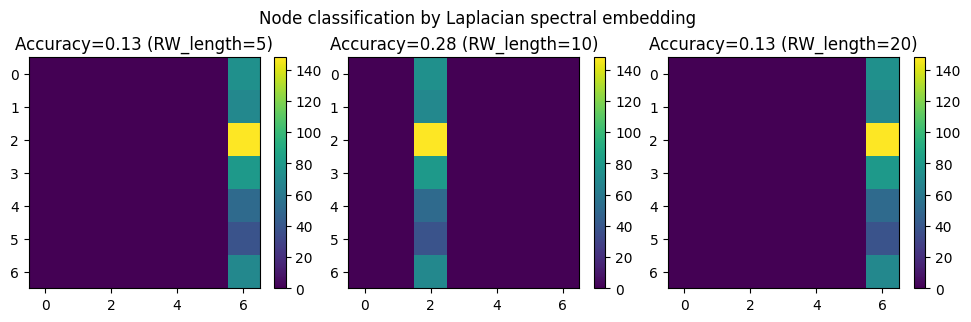

In [33]:
fig = plt.figure(figsize=[12,3], constrained_layout=False)
network_list = [""]
k_list = [5, 10, 20]
outer_grid = gridspec.GridSpec(nrows=1, ncols=len(k_list), wspace=0.1, hspace=0.1)

for i in range(len(k_list)): 
    inner_grid = outer_grid[0,i].subgridspec(1, 1, wspace=0, hspace=0)
    ax = fig.add_subplot(inner_grid[0, 0])
    k = k_list[i]
    args.update({"walk_length" : k})
    confusion_mx, acc = node_classicifation_spectral(G, node_labels, args, nodes_train, top_evecs=v,
                        classes=[0,1,2,3,4,5,6])

    im = ax.imshow(confusion_mx)
    ax.set_title("Accuracy={} (RW_length={})".format(np.round(acc,3), k))
    #cbar_ax = ax.inset_axes([0.92, 0.15, 0.01, 0.7])
    fig.colorbar(im, ax=ax)
    
plt.suptitle("Node classification by Laplacian spectral embedding", y=1.04)
plt.savefig("cora_node_classification2", bbox_inches="tight")

In [ ]:
# Spectral Embedding
#L = nx.normalized_laplacian_matrix(G).todense()
A = nx.adjacency_matrix(G).todense()
w, v = np.linalg.eigh(A)
#d = 2
#U = np.array(eigenvectors[:, :d])

In [ ]:
fig = plt.figure(figsize=[12,3], constrained_layout=False)
network_list = [""]
k_list = [5, 10, 20]
outer_grid = gridspec.GridSpec(nrows=1, ncols=len(k_list), wspace=0.1, hspace=0.1)

for i in range(len(k_list)): 
    inner_grid = outer_grid[0,i].subgridspec(1, 1, wspace=0, hspace=0)
    ax = fig.add_subplot(inner_grid[0, 0])
    k = k_list[i]
    args.update({"walk_length" : k})
    confusion_mx, acc = node_classicifation_spectral(G, node_labels, args, nodes_train, top_evecs=v,
                        classes=[0,1,2,3,4,5,6])

    im = ax.imshow(confusion_mx)
    ax.set_title("Accuracy={} (RW_length={})".format(np.round(acc,3), k))
    #cbar_ax = ax.inset_axes([0.92, 0.15, 0.01, 0.7])
    fig.colorbar(im, ax=ax)
    
plt.suptitle("Node classification by Adjacency spectral embedding", y=1.04)
plt.savefig("cora_node_classification3", bbox_inches="tight")